# Question: 2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd

from cvxpy.reductions.solvers.defines import installed_solvers
print(installed_solvers())


['CLARABEL', 'ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']


In [34]:
# load the dataset
train_data = pd.read_csv('train_svm.csv', names=['x1', 'x2', 'y'], header=None)
test_data = pd.read_csv('test_svm.csv', names=['x1', 'x2', 'y'], header=None)
print("Training data looks like: \n",train_data.head())

# Define the variables
params = cp.Variable((3, ))  # w1, w2, b

# Define the objective
objective = cp.Minimize(cp.norm(params[0:2], 2)**2 / 2)

# Define the constraints - one per training example in matrix form
# Y @ A @ [w, b].T >= 1 
rhs = np.ones((train_data.shape[0], ))
A_matrix = train_data[['x1', 'x2']].to_numpy()
y_values = train_data['y'].to_numpy()   
y_matrix = np.diag(y_values)
A_matrix = np.hstack((A_matrix, np.ones((A_matrix.shape[0], 1))))

constraint = [cp.matmul(y_matrix, A_matrix @ params) >= rhs]
problem = cp.Problem(objective, constraint)

# Solve the problem
problem.solve()

# print the results
print("Optimal parameters are: ", params.value)
print("Optimal objective value is: ", objective.value)
print("Solver details: ", problem.solver_stats)

Training data looks like: 
         x1      x2  y
0  0.10327  3.9126 -1
1  3.68390  2.7885  1
2  2.80320  1.9121  1
3  0.76037  1.3394 -1
4  3.46940  3.5608  1
Optimal parameters are:  [ 11.25572679  -1.97366043 -17.88944473]
Optimal objective value is:  65.29336055826558
Solver details:  SolverStats(solver_name='CLARABEL', solve_time=0.000200087, setup_time=None, num_iters=10, extra_stats=None)


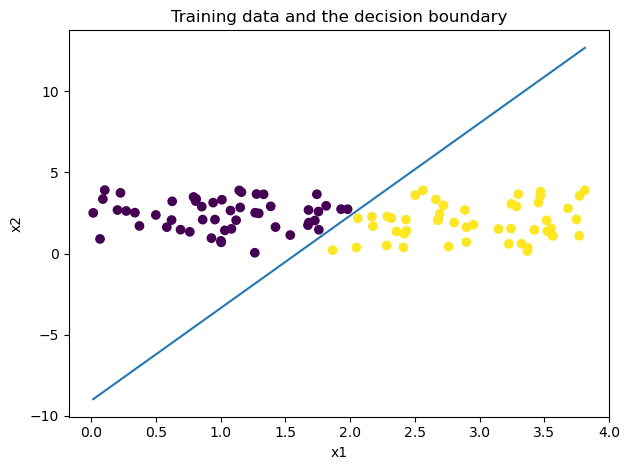

In [37]:
# Plot the line and the training data
plt.figure()
plt.scatter(train_data['x1'], train_data['x2'], c=train_data['y'])
# The line is given by f(x) = w1*x1 + w2*x2 + b = 0
min_x1, max_x1 = train_data['x1'].min(), train_data['x1'].max()
min_x2, max_x2 = train_data['x2'].min(), train_data['x2'].max()
x1 = np.linspace(min_x1, max_x1, 100)
x2 = (-params.value[0] * x1 - params.value[2]) / params.value[1]
plt.plot(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training data and the decision boundary')
plt.tight_layout()
# save as png
plt.savefig('svm_train.png')

In [40]:
# test the model
test_data['prediction'] = test_data['x1']*params.value[0] + test_data['x2']*params.value[1] + params.value[2]
test_data['prediction'] = test_data['prediction'].apply(lambda x: 1 if x > 0 else -1)
test_data['correct'] = test_data['prediction'] == test_data['y']
accuracy = test_data['correct'].sum() / test_data.shape[0]
print("Accuracy on test data is: ", accuracy)

Accuracy on test data is:  0.9766666666666667


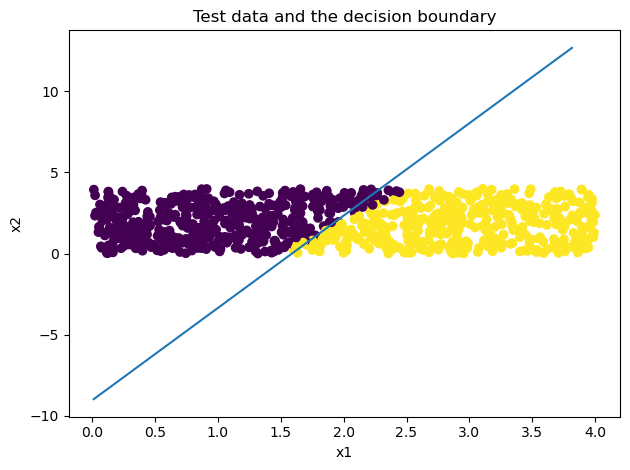

In [39]:
# plot the test data
plt.figure()
plt.scatter(test_data['x1'], test_data['x2'], c=test_data['y'])
plt.plot(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')

# plot the decision boundary
plt.title('Test data and the decision boundary')
plt.tight_layout()
plt.savefig('svm_test.png')
# print("Accuracy on test data is: ", accuracy)
